In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
tf.config.list_physical_devices('GPU')

#### Load data

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasRegressor
from keras import models
from keras import layers
from keras.layers.core import Dropout
from keras import optimizers
from keras import backend as K
from keras.layers.experimental.preprocessing import Rescaling
from sklearn.model_selection import GridSearchCV

In [3]:

with open('./NHANES_Full_trimmed_1720.csv', 'r') as f:    
    lines = f.readlines()
    header = lines[0].rstrip('\n').split(',')
    data = [header[1:]]    
        
    for line in lines[1:]:
        line = line.rstrip('\n').split(',')
        line_new = []
        for element in line:             
            if element == 'NA': 
                element = np.nan                
            elif (element.isalpha()):
                element = ord(element)                
            else:
                element = pd.to_numeric(element)
            line_new.append(element) 
        
        data.append(line_new[1:])
    f.close()

In [4]:
df_data = pd.DataFrame(data[1:], columns=data[0])
df_data.head(5)

,BMDSTATS,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,OHDDESTS,OHX01TC,...,PUQ100,PUQ110,SMAQUEX2,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMQ940,SMAQUEX
0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,...,NaN,NaN,NaN,1.0,1.0,2.0,1.0,1.0,2.0,3.0
1,1.0,42.2,154.7,17.6,36.3,33.8,22.7,63.8,1.0,4.0,...,2.0,9.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0
2,1.0,12.0,89.3,15.0,NaN,18.6,14.8,41.2,1.0,4.0,...,NaN,NaN,NaN,1.0,1.0,2.0,1.0,1.0,2.0,3.0
3,1.0,97.1,160.2,37.8,40.8,34.7,35.8,117.9,1.0,2.0,...,2.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0


In [5]:
# Recode the y label into binary
# 'DIQ010'
# 1,3: Yes (diabetic)
# 2,9: No (Non-diabetic)
replace_dict = {3: 1, 2: 0, 9: 0 }
df_data['DIQ010'] = df_data['DIQ010'].replace(replace_dict)

#### Normalization

In [6]:
# Min-Max Normalization

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(1, 2))
scaler.fit(df_data)
data_scaled_minmax = scaler.transform(df_data)

In [ ]:
# Standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_data)
data_scaled_std = scaler.transform(df_data)

In [ ]:
df_data_std = pd.DataFrame(data_scaled_std, columns=data[0])
df_data_std.head(5)

In [7]:
df_data_minmax = pd.DataFrame(data_scaled_minmax, columns=data[0])
df_data_minmax.head(5)

,BMDSTATS,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,OHDDESTS,OHX01TC,...,PUQ100,PUQ110,SMAQUEX2,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMQ940,SMAQUEX
0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.666667,...,NaN,NaN,NaN,1.000,1.0,1.125,1.0,1.000,1.125,2.0
1,1.0,1.155317,1.629843,1.070896,1.380795,1.602469,1.215760,1.161356,1.0,1.666667,...,1.125,2.000,2.0,1.125,1.0,1.125,1.0,1.000,1.125,1.0
2,1.0,1.035046,1.090684,1.038557,NaN,1.227160,1.067542,1.008136,1.0,1.666667,...,NaN,NaN,NaN,1.000,1.0,1.125,1.0,1.000,1.125,2.0
3,1.0,1.373955,1.675185,1.322139,1.529801,1.624691,1.461538,1.528136,1.0,1.000000,...,1.125,1.125,1.0,1.125,1.0,1.125,1.0,1.125,1.125,1.5
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,1.000,1.0,1.125,1.0,1.000,1.000,1.5


#### Split of complete and incomplete cases

In [104]:
df_complete = df_data_minmax[(df_data_minmax.isna().sum(axis=1) <1)]
df_incomplete = df_data_minmax[~(df_data_minmax.isna().sum(axis=1) <1)]

In [92]:
print(df_complete.shape)
print(df_incomplete.shape)
print(df_data_minmax.shape)

(4825, 167)
(10161, 167)
(15560, 167)


In [105]:
complete_x = df_complete.drop('DIQ010', axis=1).to_numpy()
complete_y = df_complete['DIQ010'].to_numpy()

In [106]:
#df_incomplete['DIQ010'].isna().sum()  # 574
df_incomplete = df_incomplete[~(df_incomplete['DIQ010'].isna())]   #(10161, 167)

incomplete_x = df_incomplete.drop('DIQ010', axis=1).to_numpy()
incomplete_y = df_incomplete['DIQ010'].to_numpy()

In [107]:
print('Complete Samples: ', complete_x.shape)
print('Incomplete Samples: ', incomplete_x.shape)

(4825, 166)
(10161, 166)


#### Splitting training, validating and testing sets 

In [13]:
from sklearn.model_selection import train_test_split
# train : test = 8 : 2 
x_train, x_test, y_train, y_test = train_test_split(complete_x, complete_y, test_size=0.2, random_state=1)

In [57]:
# validation ratio = 0.1
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=2)

In [14]:
for i in [x_train, x_test, y_train, y_test]:
    print(i.shape)

(3860, 166)
(965, 166)
(3860,)
(965,)


### DAE Model

##### Dropout layer for corrupting the complete data

In [15]:
dropout_rate = 0.2
seed = 0

# corrupt the input with a dropout layer and directly output
input_dim = (x_train.shape[1],)
inputs = keras.Input(shape=input_dim)
noising = keras.layers.Dropout(dropout_rate, seed=seed)(inputs, training=True)
outputs = Rescaling(1-dropout_rate)(noising)

model_0 = keras.Model(inputs, outputs)
model_0.compile()

model_0.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 166)]             0         
_________________________________________________________________
dropout (Dropout)            (None, 166)               0         
_________________________________________________________________
rescaling (Rescaling)        (None, 166)               0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [16]:
# obtain the output: corrupted train data
inp = model_0.input
out = model_0.output
get_output = K.function([inp], [out])
outputs = get_output([x_train])

x_train_corrupted = np.array(outputs[0])

In [17]:
import sklearn.metrics

#mse = sklearn.metrics.mean_squared_error(x_train, x_train_corrupted)
mae = sklearn.metrics.mean_absolute_error(x_train, x_train_corrupted)
print('mae: ', mae)  # The idea that if all the missing value are replaced with zero

mae:  0.2670860465051908


#### Stacking layers

In [18]:
# The Encoder and Decoder structure of the DAE
## 'Number of hidden layers' & 'reduce rate of neurons through each layer' 
##   will be determined based on the result of grid search

def AE(n_hid_layer, r):

    input_dim = (x_train.shape[1],)
    nodes = int(input_dim[0])

    ae = keras.models.Sequential()
  # input layer
    ae.add(keras.Input(shape=input_dim))
  # hidden layers  
    if (n_hid_layer %2 == 0):
        for i in range(1, (n_hid_layer//2)+1):
            ae.add(layers.Dense(nodes*pow(r, i), activation='relu'))
        for i in reversed(range(1, (n_hid_layer//2)+1)):
            ae.add(layers.Dense(nodes*pow(r, i), activation='relu'))        
    else:
        for i in range(1, (n_hid_layer//2)+1):
            ae.add(layers.Dense(nodes*pow(r, i), activation='relu'))
            
        ae.add(layers.Dense(nodes*pow(r, (n_hid_layer//2)+1), activation='relu'))        
        for i in reversed(range(1, (n_hid_layer//2)+1)):
            ae.add(layers.Dense(nodes*pow(r, i), activation='relu'))              
     
    return ae

#AE(5, 0.8).summary()

In [19]:
# compile model with functional API
## in order to activate the dropout layer (introduce noise) in 
### both training and validation phase

def DAE(n_hid_layer=5, reduce_rate=0.8): 
    inputs = keras.Input(shape=input_dim)
    noising = keras.layers.Dropout(0.2)(inputs, training=True)
    rescaling = Rescaling(0.8)(noising)
  # AE
    ae_layers = AE(n_hid_layer, reduce_rate)(rescaling)
    outputs = layers.Dense(input_dim[0], activation='linear')(ae_layers)

    dae = keras.Model(inputs, outputs)
    dae.compile(optimizer='adam', loss='mse', metrics='mae')
    return dae

#DAE().summary()

#### Hyperparameters tuning

In [ ]:
# Hyperparameters tuning with GridSearchCV

models = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=DAE)
DAE_params = {'batch_size': [40, 60],  'epochs': [500],        
              'n_hid_layer' : [3, 5, 6], 
              'reduce_rate' : [0.8, 1.2, 1.3]}  

grid = GridSearchCV(models, DAE_params, cv = 5, scoring='neg_mean_absolute_error') 

grid_result = grid.fit(x_train, x_train)

In [ ]:
print(f"Best score: {grid_result.best_score_} , best_params: {grid_result.best_params_}")

- 'batch_size': [40, 60, 100, 120, 200],  'epochs': [400, 500],        
- 'n_hid_layer' : [3, 4, 5, 6, 7], 
- 'reduce_rate' : [0.8, 0.9, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7]

- == Best score: -0.04737668 , best_params: {'batch_size': 100, 'epochs': 500, 'n_hid_layer': 3, 'reduce_rate': 2.6}

In [ ]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"mean: {mean}, STD: {stdev}, param: {param}")

#### Build a model with the best combination of hyperparameters and find the training epochs by early-stopping 

In [61]:
! mkdir train_log

In [62]:
model = DAE(3, 2.6)
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_mae', patience=50, ),  
                  keras.callbacks.TensorBoard(log_dir='train_log', histogram_freq=1,embeddings_freq=1,)]
history = model.fit(x_train, x_train, epochs=1200, batch_size=100, 
                    validation_data=(x_val, x_val),callbacks=callbacks_list)

#history = model.fit(x_train, x_train, epochs=1200, batch_size=100, validation_split=0.1, callbacks=callbacks_list)

Epoch 1/1200
35/35 [==============================] - 1s 36ms/step - loss: 0.2100 - mae: 0.2932 - val_loss: 0.0406 - val_mae: 0.1421
Epoch 2/1200
35/35 [==============================] - 1s 17ms/step - loss: 0.0362 - mae: 0.1302 - val_loss: 0.0341 - val_mae: 0.1237
Epoch 3/1200
35/35 [==============================] - 1s 15ms/step - loss: 0.0334 - mae: 0.1219 - val_loss: 0.0328 - val_mae: 0.1214
Epoch 4/1200
35/35 [==============================] - 1s 16ms/step - loss: 0.0322 - mae: 0.1188 - val_loss: 0.0315 - val_mae: 0.1174
Epoch 5/1200
35/35 [==============================] - 1s 17ms/step - loss: 0.0311 - mae: 0.1160 - val_loss: 0.0308 - val_mae: 0.1175
Epoch 6/1200
35/35 [==============================] - 1s 18ms/step - loss: 0.0302 - mae: 0.1145 - val_loss: 0.0297 - val_mae: 0.1129
Epoch 7/1200
35/35 [==============================] - 1s 17ms/step - loss: 0.0294 - mae: 0.1117 - val_loss: 0.0291 - val_mae: 0.1082
Epoch 8/1200
35/35 [==============================] - 1s 16ms/step - 

35/35 [==============================] - 1s 19ms/step - loss: 0.0145 - mae: 0.0715 - val_loss: 0.0145 - val_mae: 0.0706
Epoch 122/1200
35/35 [==============================] - 1s 18ms/step - loss: 0.0146 - mae: 0.0724 - val_loss: 0.0159 - val_mae: 0.0800
Epoch 123/1200
35/35 [==============================] - 1s 18ms/step - loss: 0.0144 - mae: 0.0721 - val_loss: 0.0148 - val_mae: 0.0735
Epoch 124/1200
35/35 [==============================] - 1s 19ms/step - loss: 0.0141 - mae: 0.0697 - val_loss: 0.0139 - val_mae: 0.0687
Epoch 125/1200
35/35 [==============================] - 1s 18ms/step - loss: 0.0140 - mae: 0.0693 - val_loss: 0.0142 - val_mae: 0.0690
Epoch 126/1200
35/35 [==============================] - 1s 18ms/step - loss: 0.0140 - mae: 0.0695 - val_loss: 0.0140 - val_mae: 0.0705
Epoch 127/1200
35/35 [==============================] - 1s 18ms/step - loss: 0.0139 - mae: 0.0687 - val_loss: 0.0141 - val_mae: 0.0705
Epoch 128/1200
35/35 [==============================] - 1s 17ms/step -

Epoch 182/1200
35/35 [==============================] - 1s 17ms/step - loss: 0.0116 - mae: 0.0617 - val_loss: 0.0119 - val_mae: 0.0608
Epoch 183/1200
35/35 [==============================] - 1s 17ms/step - loss: 0.0114 - mae: 0.0606 - val_loss: 0.0117 - val_mae: 0.0603
Epoch 184/1200
35/35 [==============================] - 1s 17ms/step - loss: 0.0113 - mae: 0.0595 - val_loss: 0.0117 - val_mae: 0.0593
Epoch 185/1200
35/35 [==============================] - 1s 17ms/step - loss: 0.0112 - mae: 0.0591 - val_loss: 0.0115 - val_mae: 0.0589
Epoch 186/1200
35/35 [==============================] - 1s 18ms/step - loss: 0.0112 - mae: 0.0593 - val_loss: 0.0117 - val_mae: 0.0612
Epoch 187/1200
35/35 [==============================] - 1s 17ms/step - loss: 0.0115 - mae: 0.0609 - val_loss: 0.0118 - val_mae: 0.0621
Epoch 188/1200
35/35 [==============================] - 1s 16ms/step - loss: 0.0113 - mae: 0.0601 - val_loss: 0.0117 - val_mae: 0.0604
Epoch 189/1200
35/35 [==============================] -

Epoch 243/1200
35/35 [==============================] - 1s 19ms/step - loss: 0.0101 - mae: 0.0541 - val_loss: 0.0105 - val_mae: 0.0548
Epoch 244/1200
35/35 [==============================] - 1s 17ms/step - loss: 0.0101 - mae: 0.0542 - val_loss: 0.0105 - val_mae: 0.0560
Epoch 245/1200
35/35 [==============================] - 1s 17ms/step - loss: 0.0101 - mae: 0.0550 - val_loss: 0.0106 - val_mae: 0.0551
Epoch 246/1200
35/35 [==============================] - 1s 16ms/step - loss: 0.0102 - mae: 0.0554 - val_loss: 0.0103 - val_mae: 0.0547
Epoch 247/1200
35/35 [==============================] - 1s 17ms/step - loss: 0.0102 - mae: 0.0553 - val_loss: 0.0106 - val_mae: 0.0583
Epoch 248/1200
35/35 [==============================] - 1s 18ms/step - loss: 0.0101 - mae: 0.0549 - val_loss: 0.0105 - val_mae: 0.0548
Epoch 249/1200
35/35 [==============================] - 1s 17ms/step - loss: 0.0102 - mae: 0.0554 - val_loss: 0.0105 - val_mae: 0.0556
Epoch 250/1200
35/35 [==============================] -

Epoch 364/1200
35/35 [==============================] - 1s 17ms/step - loss: 0.0090 - mae: 0.0498 - val_loss: 0.0095 - val_mae: 0.0508
Epoch 365/1200
35/35 [==============================] - 1s 17ms/step - loss: 0.0090 - mae: 0.0495 - val_loss: 0.0093 - val_mae: 0.0499
Epoch 366/1200
35/35 [==============================] - 1s 16ms/step - loss: 0.0091 - mae: 0.0502 - val_loss: 0.0094 - val_mae: 0.0502
Epoch 367/1200
35/35 [==============================] - 1s 17ms/step - loss: 0.0091 - mae: 0.0498 - val_loss: 0.0094 - val_mae: 0.0504
Epoch 368/1200
35/35 [==============================] - 1s 17ms/step - loss: 0.0090 - mae: 0.0495 - val_loss: 0.0096 - val_mae: 0.0518
Epoch 369/1200
35/35 [==============================] - 1s 17ms/step - loss: 0.0090 - mae: 0.0494 - val_loss: 0.0091 - val_mae: 0.0490
Epoch 370/1200
35/35 [==============================] - 1s 17ms/step - loss: 0.0089 - mae: 0.0492 - val_loss: 0.0093 - val_mae: 0.0497
Epoch 371/1200
35/35 [==============================] -

Epoch 425/1200
35/35 [==============================] - 1s 17ms/step - loss: 0.0086 - mae: 0.0482 - val_loss: 0.0088 - val_mae: 0.0480
Epoch 426/1200
35/35 [==============================] - 1s 17ms/step - loss: 0.0085 - mae: 0.0479 - val_loss: 0.0087 - val_mae: 0.0480
Epoch 427/1200
35/35 [==============================] - 1s 18ms/step - loss: 0.0083 - mae: 0.0473 - val_loss: 0.0087 - val_mae: 0.0483
Epoch 428/1200
35/35 [==============================] - 1s 17ms/step - loss: 0.0084 - mae: 0.0471 - val_loss: 0.0088 - val_mae: 0.0475
Epoch 429/1200
35/35 [==============================] - 1s 17ms/step - loss: 0.0084 - mae: 0.0471 - val_loss: 0.0086 - val_mae: 0.0472
Epoch 430/1200
35/35 [==============================] - 1s 16ms/step - loss: 0.0083 - mae: 0.0464 - val_loss: 0.0087 - val_mae: 0.0473
Epoch 431/1200
35/35 [==============================] - 1s 16ms/step - loss: 0.0084 - mae: 0.0473 - val_loss: 0.0089 - val_mae: 0.0482
Epoch 432/1200
35/35 [==============================] -

Epoch 486/1200
35/35 [==============================] - 1s 16ms/step - loss: 0.0082 - mae: 0.0456 - val_loss: 0.0087 - val_mae: 0.0476
Epoch 487/1200
35/35 [==============================] - 1s 18ms/step - loss: 0.0083 - mae: 0.0464 - val_loss: 0.0087 - val_mae: 0.0469
Epoch 488/1200
35/35 [==============================] - 1s 17ms/step - loss: 0.0083 - mae: 0.0461 - val_loss: 0.0084 - val_mae: 0.0465
Epoch 489/1200
35/35 [==============================] - 1s 17ms/step - loss: 0.0082 - mae: 0.0462 - val_loss: 0.0084 - val_mae: 0.0470
Epoch 490/1200
35/35 [==============================] - 1s 17ms/step - loss: 0.0082 - mae: 0.0457 - val_loss: 0.0086 - val_mae: 0.0466
Epoch 491/1200
35/35 [==============================] - 1s 17ms/step - loss: 0.0082 - mae: 0.0460 - val_loss: 0.0086 - val_mae: 0.0461
Epoch 492/1200
35/35 [==============================] - 1s 20ms/step - loss: 0.0084 - mae: 0.0472 - val_loss: 0.0088 - val_mae: 0.0470
Epoch 493/1200
35/35 [==============================] -

Epoch 547/1200
35/35 [==============================] - 1s 19ms/step - loss: 0.0080 - mae: 0.0445 - val_loss: 0.0084 - val_mae: 0.0455
Epoch 548/1200
35/35 [==============================] - 1s 20ms/step - loss: 0.0080 - mae: 0.0448 - val_loss: 0.0084 - val_mae: 0.0470
Epoch 549/1200
35/35 [==============================] - 1s 18ms/step - loss: 0.0082 - mae: 0.0457 - val_loss: 0.0085 - val_mae: 0.0458
Epoch 550/1200
35/35 [==============================] - 1s 18ms/step - loss: 0.0081 - mae: 0.0449 - val_loss: 0.0085 - val_mae: 0.0471
Epoch 551/1200
35/35 [==============================] - 1s 17ms/step - loss: 0.0081 - mae: 0.0449 - val_loss: 0.0083 - val_mae: 0.0456
Epoch 552/1200
35/35 [==============================] - 1s 19ms/step - loss: 0.0081 - mae: 0.0451 - val_loss: 0.0084 - val_mae: 0.0459
Epoch 553/1200
35/35 [==============================] - 1s 17ms/step - loss: 0.0081 - mae: 0.0451 - val_loss: 0.0086 - val_mae: 0.0465
Epoch 554/1200
35/35 [==============================] -

Epoch 608/1200
35/35 [==============================] - 1s 18ms/step - loss: 0.0078 - mae: 0.0445 - val_loss: 0.0082 - val_mae: 0.0464
Epoch 609/1200
35/35 [==============================] - 1s 20ms/step - loss: 0.0079 - mae: 0.0450 - val_loss: 0.0085 - val_mae: 0.0476
Epoch 610/1200
35/35 [==============================] - 1s 17ms/step - loss: 0.0078 - mae: 0.0444 - val_loss: 0.0084 - val_mae: 0.0456
Epoch 611/1200
35/35 [==============================] - 1s 19ms/step - loss: 0.0079 - mae: 0.0453 - val_loss: 0.0083 - val_mae: 0.0455
Epoch 612/1200
35/35 [==============================] - 1s 20ms/step - loss: 0.0077 - mae: 0.0436 - val_loss: 0.0085 - val_mae: 0.0474
Epoch 613/1200
35/35 [==============================] - 1s 18ms/step - loss: 0.0078 - mae: 0.0445 - val_loss: 0.0082 - val_mae: 0.0468
Epoch 614/1200
35/35 [==============================] - 1s 19ms/step - loss: 0.0078 - mae: 0.0440 - val_loss: 0.0082 - val_mae: 0.0452
Epoch 615/1200
35/35 [==============================] -

In [ ]:
! tensorboard --logdir=train_log

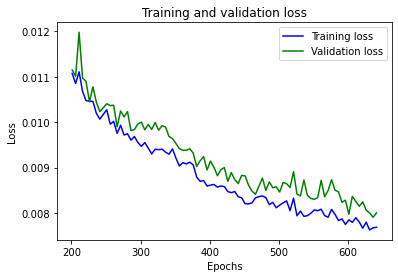

In [63]:
# Plotting the training and validation "loss" 
loss_values = history.history['loss'][200::5]
val_loss_values = history.history['val_loss'][200::5]
epochs = range(201, len(loss_values)*5 + 201, 5)

plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


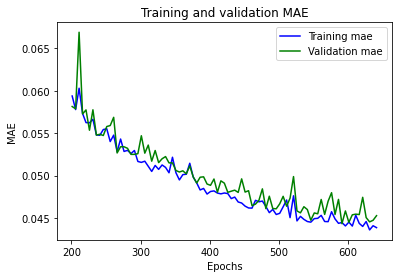

In [64]:
# Plotting the training and validation "mae" 
mae_values = history.history['mae'][200::5]
val_mae_values = history.history['val_mae'][200::5]
epochs = range(201, len(mae_values)*5 + 201, 5)
plt.plot(epochs, mae_values, 'b', label='Training mae')
plt.plot(epochs, val_mae_values, 'g', label='Validation mae')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

#### Knock out the 'noising' dropout layer

In [65]:
model.summary()

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 166)]             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 166)               0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 166)               0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 431)               1040694   
_________________________________________________________________
dense_19 (Dense)             (None, 166)               71712     
Total params: 1,112,406
Trainable params: 1,112,406
Non-trainable params: 0
_________________________________________________________________


In [66]:
model_for_imputation = keras.models.clone_model(model)
model_for_imputation.set_weights(model.get_weights())
model_for_imputation._layers.pop(1)  # remove the dropout layer
model_for_imputation._layers.pop(1)  # remove the rescaling layer
model_for_imputation.summary()

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 166)]             0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 431)               1040694   
_________________________________________________________________
dense_19 (Dense)             (None, 166)               71712     
Total params: 1,112,406
Trainable params: 1,112,406
Non-trainable params: 0
_________________________________________________________________


#### Create a 'map' of missing value

In [67]:
missing_map = np.copy(incomplete_x)
missing_map[~np.isnan(missing_map)] = False
missing_map[np.isnan(missing_map)] = True
missing_map = missing_map.astype(int, copy=False)
#missing_map[0]

#### Feed the incomplete set and get the output value

In [68]:
incomplete_x_num = np.copy(incomplete_x)
incomplete_x_num[np.isnan(incomplete_x_num)] = 0

In [69]:
from keras import backend as K
# obtain the output of an intermediate layer
inp = model_for_imputation.input
out = model_for_imputation.output
get_output = K.function([inp], [out])

outputs = get_output([incomplete_x_num])
#print(np.array(outputs)[0])
dae_predict = outputs[0]

In [ ]:
dae_predict[0]

#### Missing value imputation

In [70]:
# Imputation by DAE
## the full dataset for classification: imputation_dae
imputation_dae = np.copy(incomplete_x)
np.putmask(imputation_dae, missing_map, dae_predict)
imputation_dae = np.concatenate([complete_x, imputation_dae], axis=0)
imputation_dae.shape

(14986, 166)

In [71]:
# Imputation with column mean
## the full dataset for classification: imputation_mean
imputation_mean = np.concatenate([complete_x, incomplete_x], axis=0)
mask = np.zeros(shape=complete_x.shape, dtype=int)
mask = np.concatenate([mask, missing_map], axis=0)
imputation_mean = np.where(mask, np.nanmean(imputation_mean, axis=0), imputation_mean)
imputation_mean.shape

(14986, 166)

#### Let me check the MAE first

In [72]:
# corrupt the test set of complete cases
inp = model_0.input
out = model_0.output
get_output = K.function([inp], [out])
outputs = get_output([x_test])

x_test_corrupted = np.array(outputs[0])  

In [73]:
x_test_corrupted[x_test_corrupted==0] = np.nan

In [74]:
# missing map
masking = np.copy(x_test_corrupted)
masking[~np.isnan(masking)] = False
masking[np.isnan(masking)] = True
masking = masking.astype(int, copy=False)

In [75]:
# replace with mean
mean_replace = np.where(np.isnan(x_test_corrupted), np.nanmean(x_test_corrupted, axis=0), x_test_corrupted)

In [76]:
# imputation by dae
x_test_corrupted[np.isnan(x_test_corrupted)] = 0
inp = model_for_imputation.input
out = model_for_imputation.output
get_output = K.function([inp], [out])

outputs = get_output([x_test_corrupted])
dae_predict = outputs[0]

imput_dae = np.copy(x_test_corrupted)
np.putmask(imput_dae, masking, dae_predict)

In [77]:
# to what extent the missing values were recovered
mae_corrupt = sklearn.metrics.mean_absolute_error(x_test, x_test_corrupted)
mae_mean = sklearn.metrics.mean_absolute_error(x_test, mean_replace)
mae_dae = sklearn.metrics.mean_absolute_error(x_test, imput_dae)
print('MAE if without imputation: ', mae_corrupt)
print('MAE if imputation by mean: ', mae_mean)
print('MAE if imputation by DAE:  ', mae_dae)

MAE if without imputation:  0.2662043238335415
MAE if imputation by mean:  0.021418720774534647
MAE if imputation by DAE:   0.017297812001236236


### Classification task

#### SVM

In [117]:
from sklearn import svm
complete_y = df_complete['DIQ010'].to_numpy()
imputation_y = np.concatenate([complete_y, incomplete_y], axis=0)
complete_y_bin = np.where(complete_y==1, 0, complete_y)
complete_y_bin = np.where(complete_y==2, 1, complete_y_bin)
imputation_y_bin = np.where(imputation_y==1, 0, imputation_y)
imputation_y_bin = np.where(imputation_y==2, 1, imputation_y_bin)

In [120]:
complete_y_cat = pd.Categorical(complete_y_bin)
imputation_y_cat = pd.Categorical(imputation_y_bin)

In [133]:
# Complete 4825: train=3860, test=965
x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(complete_x, complete_y_cat, 
                                                            test_size=0.2, random_state=1)
# train classifier
clf_complete = svm.SVC()
clf_complete.fit(x_train_c, y_train_c)

y_pred_c = clf_complete.predict(x_test_c)
cm_c = sklearn.metrics.confusion_matrix(y_test_c, y_pred_c)

In [134]:
cm_c

array([[824,   0],
       [141,   0]], dtype=int64)

In [125]:
# Whole 14986: train=11988, test=2998
x_train_mean, x_test_mean, y_train_mean, y_test_mean = train_test_split(imputation_mean, imputation_y_cat, 
                                                                        test_size=0.2, random_state=1)

clf_mean = svm.SVC()
clf_mean.fit(x_train_mean, y_train_mean)

y_pred_mean = clf_mean.predict(x_test_mean)
cm_mean = sklearn.metrics.confusion_matrix(y_test_mean, y_pred_mean)

In [126]:
cm_mean

array([[2637,    0],
       [ 361,    0]], dtype=int64)

In [127]:
x_train_dae, x_test_dae, y_train_dae, y_test_dae = train_test_split(imputation_dae, imputation_y_cat, 
                                                                    test_size=0.2, random_state=1)

clf_dae = svm.SVC()
clf_dae.fit(x_train_dae, y_train_dae)

y_pred_dae = clf_dae.predict(x_test_dae)
cm_dae = sklearn.metrics.confusion_matrix(y_test_dae, y_pred_dae)

In [128]:
cm_dae

array([[2637,    0],
       [ 361,    0]], dtype=int64)

#### Well, maybe the class-imbalance issue should be considered... 

In [121]:
imputation_y_cat.describe()

,counts,freqs
categories,,
0.0,13257,0.884626
1.0,1729,0.115374


In [122]:
complete_y_cat.describe()

,counts,freqs
categories,,
0.0,4102,0.850155
1.0,723,0.149845


In [131]:
y_test_dae.describe()

,counts,freqs
categories,,
0.0,2637,0.879586
1.0,361,0.120414


In [135]:
y_test_c.describe()

,counts,freqs
categories,,
0.0,824,0.853886
1.0,141,0.146114


#### or, try to carry out the classification task by neural network

In [139]:
# build a neural network for classification 
model_clf = keras.models.Sequential()  

model_clf.add(keras.Input(shape=input_dim))
model_clf.add(layers.Dense(256, activation='relu'))
model_clf.add(layers.Dense(128, activation='relu'))
model_clf.add(layers.Dense(64, activation='relu'))
model_clf.add(layers.Dense(1, activation='sigmoid'))

model_clf.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [130]:
# Complete 4825: train=3860, test=965
x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(complete_x, complete_y_bin, 
                                                            test_size=0.2, random_state=1)

history_c = model_clf.fit(x_train_c, y_train_c, epochs=500, batch_size=100)
y_pred = model_clf.evaluate(x_test_c, y_test_c)

Epoch 1/500
39/39 [==============================] - 0s 2ms/step - loss: 0.4421 - accuracy: 0.8301
Epoch 2/500
39/39 [==============================] - 0s 2ms/step - loss: 0.4097 - accuracy: 0.8492
Epoch 3/500
39/39 [==============================] - 0s 1ms/step - loss: 0.4096 - accuracy: 0.8492
Epoch 4/500
39/39 [==============================] - 0s 2ms/step - loss: 0.3933 - accuracy: 0.8487
Epoch 5/500
39/39 [==============================] - 0s 2ms/step - loss: 0.3826 - accuracy: 0.8484
Epoch 6/500
39/39 [==============================] - 0s 2ms/step - loss: 0.3863 - accuracy: 0.8492
Epoch 7/500
39/39 [==============================] - 0s 2ms/step - loss: 0.3797 - accuracy: 0.8469
Epoch 8/500
39/39 [==============================] - 0s 2ms/step - loss: 0.3832 - accuracy: 0.8487
Epoch 9/500
39/39 [==============================] - 0s 2ms/step - loss: 0.3792 - accuracy: 0.8466
Epoch 10/500
39/39 [==============================] - 0s 2ms/step - loss: 0.3745 - accuracy: 0.8484
Epoch 11/

39/39 [==============================] - 0s 2ms/step - loss: 0.3310 - accuracy: 0.8565
Epoch 84/500
39/39 [==============================] - 0s 2ms/step - loss: 0.3193 - accuracy: 0.8614
Epoch 85/500
39/39 [==============================] - 0s 2ms/step - loss: 0.3175 - accuracy: 0.8619
Epoch 86/500
39/39 [==============================] - 0s 2ms/step - loss: 0.3393 - accuracy: 0.8583
Epoch 87/500
39/39 [==============================] - 0s 2ms/step - loss: 0.3424 - accuracy: 0.8518
Epoch 88/500
39/39 [==============================] - 0s 1ms/step - loss: 0.3216 - accuracy: 0.8606
Epoch 89/500
39/39 [==============================] - 0s 1ms/step - loss: 0.3192 - accuracy: 0.8617
Epoch 90/500
39/39 [==============================] - 0s 1ms/step - loss: 0.3282 - accuracy: 0.8567
Epoch 91/500
39/39 [==============================] - 0s 1ms/step - loss: 0.3207 - accuracy: 0.8604
Epoch 92/500
39/39 [==============================] - 0s 1ms/step - loss: 0.3193 - accuracy: 0.8606
Epoch 93/500


39/39 [==============================] - 0s 2ms/step - loss: 0.3026 - accuracy: 0.8663
Epoch 245/500
39/39 [==============================] - 0s 2ms/step - loss: 0.3255 - accuracy: 0.8575
Epoch 246/500
39/39 [==============================] - 0s 2ms/step - loss: 0.3088 - accuracy: 0.8674
Epoch 247/500
39/39 [==============================] - 0s 2ms/step - loss: 0.3002 - accuracy: 0.8674
Epoch 248/500
39/39 [==============================] - 0s 2ms/step - loss: 0.3001 - accuracy: 0.8671
Epoch 249/500
39/39 [==============================] - 0s 2ms/step - loss: 0.3030 - accuracy: 0.8653
Epoch 250/500
39/39 [==============================] - 0s 2ms/step - loss: 0.3002 - accuracy: 0.8754
Epoch 251/500
39/39 [==============================] - 0s 2ms/step - loss: 0.2953 - accuracy: 0.8725
Epoch 252/500
39/39 [==============================] - 0s 2ms/step - loss: 0.3092 - accuracy: 0.8617
Epoch 253/500
39/39 [==============================] - 0s 2ms/step - loss: 0.2995 - accuracy: 0.8692
Epoc

39/39 [==============================] - 0s 2ms/step - loss: 0.2874 - accuracy: 0.8723
Epoch 407/500
39/39 [==============================] - 0s 2ms/step - loss: 0.2772 - accuracy: 0.8782
Epoch 408/500
39/39 [==============================] - 0s 2ms/step - loss: 0.2788 - accuracy: 0.8772
Epoch 409/500
39/39 [==============================] - 0s 2ms/step - loss: 0.2831 - accuracy: 0.8728
Epoch 410/500
39/39 [==============================] - 0s 2ms/step - loss: 0.2851 - accuracy: 0.8756
Epoch 411/500
39/39 [==============================] - 0s 2ms/step - loss: 0.2718 - accuracy: 0.8772
Epoch 412/500
39/39 [==============================] - 0s 2ms/step - loss: 0.2798 - accuracy: 0.8744
Epoch 413/500
39/39 [==============================] - 0s 2ms/step - loss: 0.2733 - accuracy: 0.8782
Epoch 414/500
39/39 [==============================] - 0s 2ms/step - loss: 0.2953 - accuracy: 0.8720
Epoch 415/500
39/39 [==============================] - 0s 2ms/step - loss: 0.2896 - accuracy: 0.8715
Epoc

loss: 0.3732 - accuracy: 0.8497

In [141]:
# Whole 14986: train=11988, test=2998
x_train_mean, x_test_mean, y_train_mean, y_test_mean = train_test_split(imputation_mean, imputation_y_bin, 
                                                                    test_size=0.2, random_state=1)
history_mean = model_clf.fit(x_train_mean, y_train_mean, epochs=500, batch_size=100)
y_pred = model_clf.evaluate(x_test_mean, y_test_mean)

Epoch 1/500
120/120 [==============================] - 0s 2ms/step - loss: 0.3486 - accuracy: 0.8800
Epoch 2/500
120/120 [==============================] - 0s 1ms/step - loss: 0.3070 - accuracy: 0.8845
Epoch 3/500
120/120 [==============================] - 0s 1ms/step - loss: 0.3023 - accuracy: 0.8857
Epoch 4/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2893 - accuracy: 0.8856
Epoch 5/500
120/120 [==============================] - 0s 1ms/step - loss: 0.2863 - accuracy: 0.8861
Epoch 6/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2842 - accuracy: 0.8856: 0s - loss: 0.2917 - accuracy: 0.
Epoch 7/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2759 - accuracy: 0.8860
Epoch 8/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2819 - accuracy: 0.8860
Epoch 9/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2749 - accuracy: 0.8861
Epoch 10/500
120/120 [==============================] - 0

120/120 [==============================] - 0s 1ms/step - loss: 0.2489 - accuracy: 0.8906
Epoch 82/500
120/120 [==============================] - 0s 1ms/step - loss: 0.2545 - accuracy: 0.8880
Epoch 83/500
120/120 [==============================] - 0s 1ms/step - loss: 0.2470 - accuracy: 0.8915
Epoch 84/500
120/120 [==============================] - 0s 1ms/step - loss: 0.2534 - accuracy: 0.8900
Epoch 85/500
120/120 [==============================] - 0s 1ms/step - loss: 0.2467 - accuracy: 0.8921
Epoch 86/500
120/120 [==============================] - 0s 1ms/step - loss: 0.2505 - accuracy: 0.8917
Epoch 87/500
120/120 [==============================] - 0s 1ms/step - loss: 0.2460 - accuracy: 0.8922
Epoch 88/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2493 - accuracy: 0.8904
Epoch 89/500
120/120 [==============================] - 0s 1ms/step - loss: 0.2456 - accuracy: 0.8916
Epoch 90/500
120/120 [==============================] - 0s 1ms/step - loss: 0.2480 - accuracy: 

120/120 [==============================] - 0s 1ms/step - loss: 0.2363 - accuracy: 0.8954
Epoch 240/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2372 - accuracy: 0.8963
Epoch 241/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2354 - accuracy: 0.8952
Epoch 242/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2421 - accuracy: 0.8921
Epoch 243/500
120/120 [==============================] - ETA: 0s - loss: 0.2370 - accuracy: 0.89 - 0s 2ms/step - loss: 0.2340 - accuracy: 0.8975
Epoch 244/500
120/120 [==============================] - 0s 1ms/step - loss: 0.2305 - accuracy: 0.8974
Epoch 245/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2355 - accuracy: 0.8964
Epoch 246/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2361 - accuracy: 0.8933
Epoch 247/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2450 - accuracy: 0.8913
Epoch 248/500
120/120 [======================

120/120 [==============================] - 0s 2ms/step - loss: 0.2138 - accuracy: 0.9074
Epoch 398/500
120/120 [==============================] - 0s 1ms/step - loss: 0.2160 - accuracy: 0.9040
Epoch 399/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2178 - accuracy: 0.9013
Epoch 400/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2208 - accuracy: 0.9015
Epoch 401/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2133 - accuracy: 0.9047
Epoch 402/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2117 - accuracy: 0.9066
Epoch 403/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2143 - accuracy: 0.9047
Epoch 404/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2097 - accuracy: 0.9067
Epoch 405/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2149 - accuracy: 0.9039
Epoch 406/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2139 - a

loss: 0.3113 - accuracy: 0.8716

In [138]:
#x_train_dae, x_test_dae, y_train_dae, y_test_dae
x_train_dae, x_test_dae, y_train_dae, y_test_dae = train_test_split(imputation_dae, imputation_y_bin, 
                                                                    test_size=0.2, random_state=1)

history_dae = model_clf.fit(x_train_dae, y_train_dae, epochs=500, batch_size=100)
y_pred = model_clf.evaluate(x_test_dae, y_test_dae)

Epoch 1/500
120/120 [==============================] - 0s 2ms/step - loss: 0.3216 - accuracy: 0.8851
Epoch 2/500
120/120 [==============================] - 0s 2ms/step - loss: 0.3011 - accuracy: 0.8851
Epoch 3/500
120/120 [==============================] - 0s 1ms/step - loss: 0.2956 - accuracy: 0.8853
Epoch 4/500
120/120 [==============================] - 0s 1ms/step - loss: 0.2943 - accuracy: 0.8851
Epoch 5/500
120/120 [==============================] - 0s 1ms/step - loss: 0.2829 - accuracy: 0.8861
Epoch 6/500
120/120 [==============================] - 0s 1ms/step - loss: 0.2840 - accuracy: 0.8856
Epoch 7/500
120/120 [==============================] - 0s 1ms/step - loss: 0.2759 - accuracy: 0.8856
Epoch 8/500
120/120 [==============================] - 0s 1ms/step - loss: 0.2869 - accuracy: 0.8852
Epoch 9/500
120/120 [==============================] - 0s 1ms/step - loss: 0.2781 - accuracy: 0.8859
Epoch 10/500
120/120 [==============================] - 0s 1ms/step - loss: 0.2756 - accura

120/120 [==============================] - 0s 2ms/step - loss: 0.2397 - accuracy: 0.8945
Epoch 161/500
120/120 [==============================] - 0s 1ms/step - loss: 0.2394 - accuracy: 0.8942
Epoch 162/500
120/120 [==============================] - 0s 1ms/step - loss: 0.2402 - accuracy: 0.8932
Epoch 163/500
120/120 [==============================] - 0s 1ms/step - loss: 0.2432 - accuracy: 0.8950
Epoch 164/500
120/120 [==============================] - 0s 1ms/step - loss: 0.2413 - accuracy: 0.8958
Epoch 165/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2405 - accuracy: 0.8973
Epoch 166/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2404 - accuracy: 0.8956
Epoch 167/500
120/120 [==============================] - 0s 1ms/step - loss: 0.2437 - accuracy: 0.8942
Epoch 168/500
120/120 [==============================] - 0s 1ms/step - loss: 0.2403 - accuracy: 0.8959
Epoch 169/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2449 - a

120/120 [==============================] - 0s 2ms/step - loss: 0.2271 - accuracy: 0.9005
Epoch 319/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2267 - accuracy: 0.9022
Epoch 320/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2323 - accuracy: 0.9005
Epoch 321/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2211 - accuracy: 0.9040
Epoch 322/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2267 - accuracy: 0.8991
Epoch 323/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2225 - accuracy: 0.9046
Epoch 324/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2279 - accuracy: 0.9024
Epoch 325/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2265 - accuracy: 0.9035
Epoch 326/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2257 - accuracy: 0.9021
Epoch 327/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2270 - a

120/120 [==============================] - 0s 2ms/step - loss: 0.1965 - accuracy: 0.9146
Epoch 477/500
120/120 [==============================] - 0s 2ms/step - loss: 0.1949 - accuracy: 0.9153
Epoch 478/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2035 - accuracy: 0.9117
Epoch 479/500
120/120 [==============================] - 0s 2ms/step - loss: 0.1916 - accuracy: 0.9175
Epoch 480/500
120/120 [==============================] - 0s 2ms/step - loss: 0.2126 - accuracy: 0.9095
Epoch 481/500
120/120 [==============================] - 0s 2ms/step - loss: 0.1982 - accuracy: 0.9147
Epoch 482/500
120/120 [==============================] - 0s 2ms/step - loss: 0.1982 - accuracy: 0.9143
Epoch 483/500
120/120 [==============================] - 0s 2ms/step - loss: 0.1926 - accuracy: 0.9158
Epoch 484/500
120/120 [==============================] - 0s 2ms/step - loss: 0.1904 - accuracy: 0.9194
Epoch 485/500
120/120 [==============================] - 0s 2ms/step - loss: 0.1918 - a

loss: 0.3635 - accuracy: 0.8823

#### Files backup on Github

In [ ]:
! git remote add origin https://github.com/shelly3025/FinalProject_DAE.git
! git branch -M main
! git push -u origin main

In [1]:
! git add -A
! git commit -m "7th commit-20220107"

The file will have its original line endings in your working directory


[main 6353769] 7th commit-20220107
 1 file changed, 3289 insertions(+), 1850 deletions(-)


In [2]:
! git log --oneline

6353769 7th commit-20220107
ec5c762 6th commit-20211228
6542403 5th commit-20211227
9ff2d89 4th commit-20211225
df0cc61 3rd commit-20211224
85a84f1 2nd commit-20211223
aff242d first commit-20211222


In [ ]:
! git push